In [1]:

import pygame
import random
import os
import time
import numpy as np
import math
import torch
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)


pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
cuda:0


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
global target_order
global temp_list
temp_list = []
Agent_number_n=3
Alpha = 0.666;



In [3]:
global temp_list
temp_list = []
def appen(_x_list,y):
    global temp_list
    temp_list.append(_x_list)
    
def appen_train(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    
    training_data.append(temp_list)
    training_label.append(S)
    

def read_training_data():
    for i in range(100000):
        appen_train(sorted(np.random.rand(Agent_number_n), reverse=True));

training_data=[]
training_label=[]
S=1.0
read_training_data();

def appen_test(x_list):
    global temp_list
                
    S= max(sum(x_list),1.0);
    temp_list = []
    
    for i in range(Agent_number_n):
        temp = []
        for j in range(Agent_number_n):
            if(i!=j):
                temp.append(x_list[j])
        appen(temp,S)
    testing_data.append(temp_list)
    testing_label.append(S)
    

def read_testing_data():
#     devided=20
#     for i1 in range(devided+1):
#         for i2 in range(i1+1):
#             for i3 in range(i2+1):
#                 appen_test(i1/devided,i2/devided,i3/devided);
    for i in range(100000):
        appen_test(sorted(np.random.rand(Agent_number_n), reverse=True));
                            

testing_data=[]
testing_label=[]
S=1.0
read_testing_data();

training_data=np.array(training_data)
training_label=np.array(training_label)
testing_data=np.array(testing_data)
testing_label=np.array(testing_label)
# print(training_data)
# print(testing_data)
# print(training_label)
# print(testing_label)

In [4]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0.0,std =0.2)
        torch.nn.init.normal_(m.bias, mean=0.0,std =0.1)

        

class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()
        
        self.input_dim = Agent_number_n-1+1
        self.hidden_dim = 5
        self.output_dim = 1
        self.hidden_layer_count = 1 
        
        current_dim = self.input_dim
        self.layers = torch.nn.ModuleList()
        for i in range(self.hidden_layer_count):
            self.layers.append(torch.nn.Linear(current_dim, self.hidden_dim))
            current_dim = self.hidden_dim
        self.layers.append(torch.nn.Linear(current_dim, self.output_dim))

    def calculate(self, value_list):
        h = torch.cat([torch.tensor([torch.sum(value_list)]).cuda(),value_list])
        for layer in self.layers:
            h = torch.relu(layer(h))
        return h

    def forward(self, input_list,input_label,label):
        global iteration,echo,target_order
        loss1 = 0
        loss2 = 0
        input_list = torch.from_numpy(
            np.array(input_list)).cuda().type(torch.float32)
        h_list = []


        for i in range(Agent_number_n):
            h = self.calculate(input_list[i])
            h_list.append(h)
        input_label = torch.from_numpy(
            np.array(input_label)).cuda().type(torch.float32)
        sum_h = torch.sum(torch.cat(h_list)).cuda()


        loss1 = torch.where((Agent_number_n-1)*input_label>sum_h,
                        torch.square(((Agent_number_n-1)*input_label-sum_h)),
                        torch.zeros(1).cuda()
                      )

        loss2 = torch.where((Agent_number_n-Alpha)*input_label<sum_h,
                        torch.square((sum_h-(Agent_number_n-Alpha)*input_label)),
                        torch.zeros(1).cuda()
                      )

#         loss1 = torch.relu(((Agent_number_n-1)*input_label-sum_h))

#         loss2 = torch.relu((sum_h-(Agent_number_n-Alpha)*input_label))
        
        return loss1,loss2,h_list

In [5]:
random.seed(2000)
torch.manual_seed(256)
net  = Net()
net.apply(weight_init)
#net = torch.load("save/Deep_learning_3_small")
net.to(dev)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [6]:
#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.00001)
optimizer = opt.Adam(net.parameters(), lr=0.0001)

batch_size = 64
echo = 3

In [7]:
for iteration in range(int(echo)):
    # offender_types = []
    # defender_types = []
    
    
    X_train_list = []
    temp_number = 0
    total_batch_loss = 0 
    while(temp_number<len(training_data)-1):
        
        loss2_list = []
        loss1_sum = 0
        loss2_sum = 0
        denominator = 0
        for index in range(temp_number, min(batch_size+temp_number,len(training_data))):
            h_loss1,h_loss2,h_list = net(training_data[index],training_label[index],0)
            denominator += 1
            loss1_sum += h_loss1
            loss2_sum += h_loss2
            
        loss_sum = loss1_sum + loss2_sum
        loss = (loss_sum) / denominator 
        total_batch_loss +=float(loss_sum)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        temp_number = index
        
        if(random.random()<=0.01):
            print(temp_number,loss,float(loss1_sum),float(loss2_sum))


    print("batch iteration", iteration)
    print("batch_loss: %.2f " % (total_batch_loss/len(training_data)))
    
    print()
    print()

3024 tensor([6.7042], device='cuda:0', grad_fn=<DivBackward0>) 429.0714111328125 0.0
4347 tensor([7.8711], device='cuda:0', grad_fn=<DivBackward0>) 503.75262451171875 0.0
8883 tensor([6.0551], device='cuda:0', grad_fn=<DivBackward0>) 387.52813720703125 0.0
13104 tensor([6.5861], device='cuda:0', grad_fn=<DivBackward0>) 421.5131530761719 0.0
16128 tensor([5.6709], device='cuda:0', grad_fn=<DivBackward0>) 362.9378967285156 0.0
25011 tensor([6.6091], device='cuda:0', grad_fn=<DivBackward0>) 422.9841003417969 0.0
35091 tensor([5.0140], device='cuda:0', grad_fn=<DivBackward0>) 320.8963623046875 0.0
36351 tensor([5.3081], device='cuda:0', grad_fn=<DivBackward0>) 339.7203369140625 0.0
36666 tensor([4.5051], device='cuda:0', grad_fn=<DivBackward0>) 288.3284606933594 0.0
56007 tensor([3.4945], device='cuda:0', grad_fn=<DivBackward0>) 223.6488800048828 0.0
68103 tensor([2.8214], device='cuda:0', grad_fn=<DivBackward0>) 180.56838989257812 0.0
68166 tensor([1.8122], device='cuda:0', grad_fn=<DivBa

2.937979996204376 1.401709496974945 1.5362704992294312


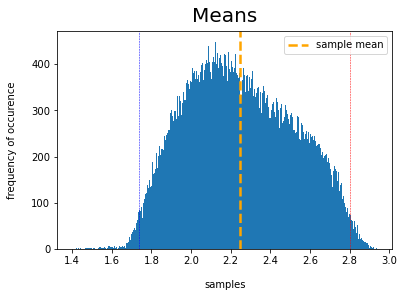

In [8]:
denominator = 0
result_list = []
for index in range(len(testing_data)):
    h_list = []
    for i in range(Agent_number_n):
        h = net.calculate(torch.tensor(testing_data[index][i]).cuda().type(torch.float32))
        h_list.append(float(h))
    
    #print(sum(h_list),h_list,sum(h_list)/testing_label[index])
    result_list.append(sum(h_list)/testing_label[index])
    

print(max(result_list),min(result_list),max(result_list)-min(result_list))

plt.hist(result_list,bins=500)

plt.title("Means", y=1.015, fontsize=20)
plt.axvline(x=sum(result_list)/len(result_list), linestyle='--', linewidth=2.5, label="sample mean", c='orange')
plt.xlabel("samples", labelpad=14)
plt.ylabel("frequency of occurence", labelpad=14)
plt.legend();

result_list.sort()

plt.axvline(x=result_list[int(len(result_list)*0.01)], linestyle='--', linewidth=0.5, label="1%", c='b')
plt.axvline(x=result_list[int(len(result_list)*0.99)], linestyle='--', linewidth=0.5, label="99%", c='r')


plt.show()

In [9]:
torch.save(net, "save/Deep_learning_3_small")